**Attribution:** These notebooks were originally developed by Mary Wotters and have possibly been modified by Nima Anari and Moses Charikar. Please direct any concerns to Nima and Moses.


# Lecture 1: Multiplication

In this IPython notebook, we implement the algorithms that we discussed in class for multiplying integers.

## The goal:

Multiply two n-digit integers. 

## The rules: 

We are allowed to use Python's built-in multiplication to do one-digit multiplications (eg, 6 times 7), but not any other multiplication (eg, 66 times 77).  We are allowed to use Python's built-in addition (even of large numbers).

In [1]:
# first include a few helper functions that will be useful (like turning integers to digits and back)
from multHelpers import *
# set up matplotlib, for plotting stuff.
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

## Here's our benchmark: grade-school multiplication.

This is probably (equivalent to) the algorithm you learned in grade school.

In [3]:
# look at each pair of digits, and add them up with appropriate shifts.
def gradeSchoolMult( X, Y ): # X and Y are integers
    x = getDigits(X)
    y = getDigits(Y)
    summands = []
    for xDigit in range(len(x)):  # 遍历 X， 按位取值
        currentXDigit = x[len(x) - xDigit -1]
        z = [0 for i in range(xDigit)] # z is the digits of xDigit times y; start it out with some zeros
        carry = 0
        for yDigit in range(len(y)):  # 遍历 Y， 按位取值
            newProd = getDigits( currentXDigit * y[len(y) - yDigit - 1] + carry )
            z.insert( 0, newProd[-1] ) # put the new digit at the front of our new summand
            if len(newProd) > 1:
                carry = newProd[0]
            else:
                carry = 0
        z.insert(0, carry)
        summands.append(makeInt(z))
    return sum(summands) # finally add them all together

In [15]:
# make sure it works on an example:

## NOTE: when testing your own code (for anything, not just this class), you'd want to do much more thorough tests!  

X = 1234567
Y = 654321

import time, math
t1 , _ = math.modf(time.time())
print(gradeSchoolMult(X,Y))
t2, _ = math.modf(time.time())
print(X*Y)
t3, _ = math.modf(time.time())
print(t2 - t1, t3 - t2)

807803114007
807803114007
0.0 0.00099945068359375


Now let's see how long this takes!  We'll try it a bunch of times and graph it.  

#### *NOTE*: Don't worry too much (at all) about the plotting code below, you'll never have to generate that for yourself in this course.

#### *NOTE*: This should work fine if you installed Jupyter using anaconda but if you did it in a different way you may need to install matplotlib.

In [16]:
# Generate some evaluation points
# 2^[1-9] 次方
nVals = [2**k for k in range(9)] # let's try it at a bunch of powers of 2, we'll see why later...
# [1, 10]* 10
nVals += [k*10 for k in range(10)]
# [2,11] * 50
nVals += [k*50 for k in range(2,11)]# plus some spaced-out points...
nVals.sort() # put them in order ???

# multABunch (included from multABunch.py) just runs this algorithm a bunch of times.
nValsGS, tValsGS = multABunch(gradeSchoolMult, nVals, numTrials=5)

nice polynomial is 7.934508452673406 + -0.34060874623735 *x +  0.0036311187503455422 x^2


Text(0.5, 1.0, 'Multiplying n-digit integers')

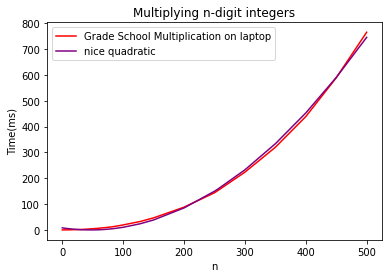

In [18]:
# Now make a pretty picture!  

plt.plot(nValsGS, tValsGS, color="red", label="Grade School Multiplication on laptop")
# after we look at the data, change the False flag to True to fit a quadratic
if True:
    coeffs = np.polyfit( nValsGS, tValsGS, 2 )  # 
    plt.plot(nValsGS, [ coeffs[2] + coeffs[1]*n + coeffs[0]*n**2 for n in nValsGS], color="purple", label="nice quadratic")
    print("nice polynomial is", coeffs[2] ,"+", coeffs[1],"*x + ", coeffs[0] , "x^2")
plt.xlabel("n")
plt.ylabel("Time(ms)")
plt.legend()
plt.title("Multiplying n-digit integers")


Text(0.5, 1.0, 'Multiplying n-digit integers')

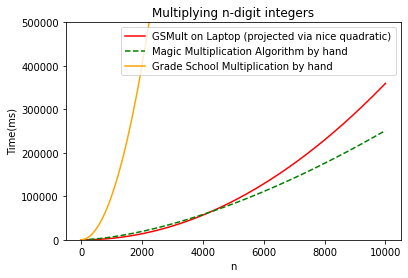

In [19]:
# Let's try interpolating this out a bit (see slides for context)

nValsTmp = range(10000)
plt.plot(nValsTmp, [ coeffs[2] + coeffs[1]*n + coeffs[0]*n**2 for n in nValsTmp], color="red", label="GSMult on Laptop (projected via nice quadratic)")
#plt.plot(nValsGS, tValsGS, color="red", label="Grade School Multiplication on laptop")
plt.plot(nValsTmp, [ n**(1.6)/10 + 100 for n in nValsTmp], "--" , color="green", label="Magic Multiplication Algorithm by hand")
plt.plot(nValsTmp, [ n**(2)/10 + 100 for n in nValsTmp], color="orange", label="Grade School Multiplication by hand")
plt.xlabel("n")
plt.ylabel("Time(ms)")
plt.ylim(0,500000)
plt.xlim()
plt.legend()
plt.title("Multiplying n-digit integers")

### Now let's try a divide-and-conquer solution!

This algorithm breaks one size-n multiplication into four size n/2 multiplications, and recurses.

In [21]:
def divideAndConquerMult1( X, Y ):
    return divideAndConquerMult1_helper( getDigits(X), getDigits(Y) )

def divideAndConquerMult1_helper( x, y ):
    n = max( len(x), len(y) )
    # pad the shorter one with zeros until it's the same length
    while len(x) < n:
        x.insert(0,0)
    while len(y) < n:
        y.insert(0,0)
    if n == 1:
        return x[0]*y[0] # this is the base case, we are allowed to multiply one-digit integers :)
    mid = round(n/2)
    xhigh = x[:mid] # this is [ x[0], x[1], ..., x[mid-1] ]
    xlow = x[mid:] # this is [ x[mid], ..., x[n-1] ]
    yhigh = y[:mid]
    ylow = y[mid:]
    highhigh = divideAndConquerMult1_helper( xhigh , yhigh )
    highlow = divideAndConquerMult1_helper( xhigh , ylow )
    lowhigh = divideAndConquerMult1_helper( xlow , yhigh )
    lowlow = divideAndConquerMult1_helper( xlow , ylow )
    
    # now shift things appropriately (see slides for explanation) and add them together
    HH = getDigits(highhigh) + [ 0 for i in range(2*(n - mid))]
    MID = getDigits(lowhigh + highlow) + [0 for i in range(n-mid)]
    LL = getDigits(lowlow)
    result = makeInt(HH) + makeInt(MID) + makeInt(LL)
    return result

In [22]:
# make sure it works on an example:

X = 1234567
Y = 654321
print(divideAndConquerMult1(X,Y))
print(X*Y)

807803114007
807803114007


How fast is this?  Let's try it!

In [9]:
nValsRec, tValsRec = multABunch(divideAndConquerMult1, nVals, numTrials=5)

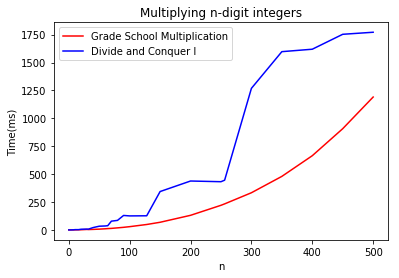

In [10]:
plt.plot(nValsGS, tValsGS, color="red", label="Grade School Multiplication")
plt.plot(nValsRec, tValsRec, color="blue", label="Divide and Conquer I")
plt.xlabel("n")
plt.ylabel("Time(ms)")
plt.legend()
plt.title("Multiplying n-digit integers")

Hmm...pretty hard to tell from this plot which one is asymptotically better.  (And there's definitely something weird going on at powers of two in the divide-and-conquer implementation above).  We'll need to turn to some mathematical analysis to understand how this algorithm behaves as n gets large.

## Karatsuba multiplication

The previous algorithms ended up both using about n^2 operations.  Karatsuba multiplication will do better!  It is also a divide-and-conquer approach, but turns one multiplication of size n into three multiplications of size n/2.

In [11]:
def karatsuba( X, Y ):
    return karatsuba_helper( getDigits(X), getDigits(Y))

def karatsuba_helper( x, y ):  
    n = max( len(x), len(y) )
    # pad the shorter one with zeros until it's the same length
    while len(x) < n:
        x.insert(0,0)
    while len(y) < n:
        y.insert(0,0)
    if n == 1:
        return x[0]*y[0] # this is the base case, we are allowed to multiply one-digit integers :)
    mid = round(n/2)
    xhigh = x[:mid] # this is [ x[0], x[1], ..., x[mid-1] ]
    xlow = x[mid:] # this is [ x[mid], ..., x[n-1] ]
    yhigh = y[:mid]
    ylow = y[mid:]
    highhigh = karatsuba_helper( xhigh , yhigh )
    lowlow = karatsuba_helper( xlow , ylow )
    tmpTerm = karatsuba_helper( getDigits( makeInt(xlow) + makeInt(xhigh) ) , getDigits( makeInt(ylow) + makeInt(yhigh) ) )
    middleTerm = tmpTerm - highhigh - lowlow # this is equal to highlow + lowhigh in divideAndConquerMult1
    HH = getDigits(highhigh) + [ 0 for i in range(2*(n - mid))]
    MID = getDigits(middleTerm) + [0 for i in range(n-mid)]
    LL = getDigits(lowlow)
    result = makeInt(HH) + makeInt(MID) + makeInt(LL)
    return result

In [12]:
# make sure it works on an example:

X = 1234567
Y = 654321
print(karatsuba(X,Y))
print(X*Y)

807803114007
807803114007


In [13]:
nValsKarat, tValsKarat = multABunch(karatsuba, nVals, numTrials=5)

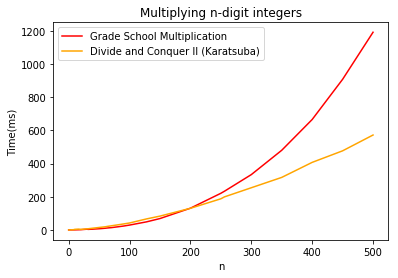

In [14]:
plt.plot(nValsGS, tValsGS, color="red", label="Grade School Multiplication")
#plt.plot(nValsRec, tValsRec, color="grey", label="Divide and Conquer I")
plt.plot(nValsKarat, tValsKarat, color="orange", label="Divide and Conquer II (Karatsuba)")
plt.xlabel("n")
plt.ylabel("Time(ms)")
plt.legend()
plt.title("Multiplying n-digit integers")

Cool, it does seem to work better than grade-school multiplication!